<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/computer_vision/mask_rcnn_object_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask R-CNN - Object detection and segmentation
Detekcja i segmaentacja obiektów

### Klonujemy repozytorium

In [0]:
# na początek czyścimy katalog roboczy
%%bash
rm -rf /content/*

In [0]:
!git clone -q https://github.com/matterport/Mask_RCNN.git

### Dodajemy do PATH ścieżki: `/content/MASK_RCNN`, `/content?MASK_RCNN/samples/coco`




In [4]:
import os
import sys
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

In [5]:
ROOT_DIR = os.getcwd()
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN/samples/coco/'))
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/Mask_RCNN',
 '/content/Mask_RCNN/samples/coco/']

In [10]:
# korzystamy z wersji tensorflow 1.15
# z najnowszą 2.0 nie jest to kompatybilne
%tensorflow_version 1.x
import tensorflow as tf
import pandas as pd
import random
import cv2
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
import coco
tf.__version__

'1.15.0'

### Tworzymy katalog `logs` oraz `images`

In [0]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')
IMAGE_DIR = os.path.join(ROOT_DIR, 'image')

for path in [MODEL_DIR, IMAGE_DIR]:
  if not os.path.exists(path):
    os.mkdir(path)

### Pobieramy i wczytujemy model (konfigurację oraz przetrenowane wagi modelu) `mask_rcnn_coco.h5`

In [8]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'mask_rcnn_coco.h5')
if not os.path.exists(COCO_MODEL_PATH):
  utils.download_trained_weights(COCO_MODEL_PATH)

class InferenceConfig(coco.CocoConfig):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

... done downloading pretrained model!

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE

In [11]:
model = modellib.MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=config)

model.load_weights(COCO_MODEL_PATH, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.








### Wczytujemy klasy z pliku

In [15]:
url = ('https://raw.githubusercontent.com/krakowiakpawel9/'
      'computer-vision-course/master/09_object-segmentation/class_names.csv')

class_names = pd.read_csv(url)
class_names = class_names['class'].tolist()
print(class_names)

['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


### Wnioskujemy na podstawie modelu

Processing 1 images
image                    shape: (640, 425, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


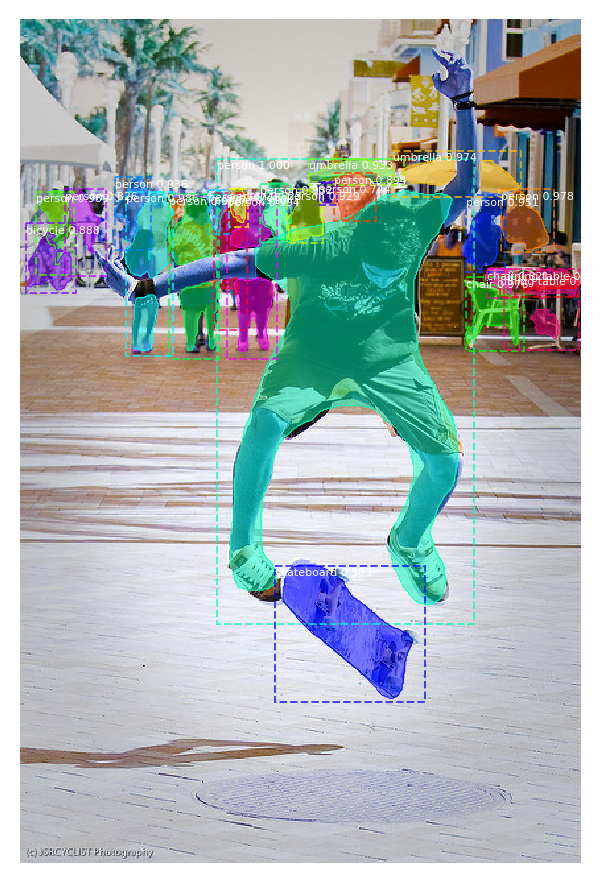

In [27]:
filename = '/content/Mask_RCNN/images/2502287818_41e4b0c4fb_z.jpg'

image = cv2.imread(os.path.join(IMAGE_DIR, filename))
results = model.detect([image], verbose=1)
result = results[0]

visualize.display_instances(image, result['rois'], result['masks'],
                            result['class_ids'], class_names, result['scores'])